# Laboratory work 1 (variant 3)
## Reporter: Kovaleva Maria 
### Description: 
Visualize empricial distribution of model parameters with dependence on the hidden layer neuron number (use different neuro number values, including underparameterized and overparameterized models). Model: 1-layer neural network. Dataset: MNIST or similar.

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

### Dataset: MNIST
The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size 28x28 image.

In [2]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.ToTensor()),
    batch_size=1000)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



### Model: 1 hidden-layer neural network
Model consists of:
> 1) Linear layer "fc1": input dim = 784, output dim = num_of_hidden

> 2) ReLU

> 3) Linear layer "fc2": input dim = num_of_hidden, output dim = 10

> 4) Softmax

num_of_hidden is  hidden layer neuron number. This parameter can be changed.

In [3]:
class MnistModel(nn.Module):
    def __init__(self, num_of_hidden = 50):
        super(MnistModel, self).__init__()
        self.num_of_hidden = num_of_hidden
        self.fc1 = nn.Linear(28*28, num_of_hidden)
        self.fc2 = nn.Linear(num_of_hidden, 10)
        
    def forward(self, x):
        y = x.view(x.shape[0],-1)
        y = F.relu(self.fc1(y))
        y = self.fc2(y)
        return F.log_softmax(y)

### Training
The negative log likelihood loss is used for training and evaluaton results. Acccuracy is also observed metric. 

In [4]:
def train_model(model, model_name, optimizer):
    print(model_name)
    train_loss = []
    train_accu = []

    test_loss = []
    test_accu = []

    i = 0
    for epoch in tqdm(range(15)):
        for data, target in train_loader:
            model.train()
            data, target = Variable(data), Variable(target)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()    # calc gradients
            train_loss.append(loss.data.item())
            optimizer.step()   # update gradients
            prediction = output.data.max(1)[1]   # first column has actual prob.
            accuracy = prediction.eq(target.data).sum()/batch_size*100
            train_accu.append(accuracy)
            
            if i % 1000 == 0:
                model.eval()
                test_correct = 0
                for test_data, test_target in test_loader:
                    test_data, test_target = Variable(test_data, volatile=True), Variable(test_target)
                    test_output = model(test_data)
                    test_loss_ = F.nll_loss(test_output, test_target)
                    test_prediction = test_output.data.max(1)[1]
                    test_correct += test_prediction.eq(test_target.data).sum()
                    test_accuracy = 100. * test_correct / len(test_loader.dataset)
                test_loss.append(test_loss_.data.item())
                test_accu.append(test_accuracy)
                #print("Step: {}".format(i))    
                #print('Train : Loss: {:.3f}\tAccuracy: {:.3f}%'.format(loss.data.item(), accuracy))
                #print('Test  : Loss: {:.3f}\tAccuracy: {:.3f}%\n'.format(test_loss_.data.item(), test_accuracy))
            i += 1
        
    plt.plot(train_loss)
    plt.plot([i * 1000 for i in range(int(len(train_loss) / 1000) + 1)], test_loss)
    plt.title(model_name + ": Loss")
    plt.show()

    plt.plot(train_accu)
    plt.plot([i * 1000 for i in range(int(len(train_accu) / 1000) + 1)], test_accu)
    plt.title(model_name + ": Accuracy")
    plt.show()

Models with different num_of_hidden parameter are being explored. In this work num_of_hidden from {2, 5, 10, 20, 50, 100, 1500} were taken. All learning curves are displayed.

All the parameters of trained models are saved for further visualization.  

MODEL 2


100%|██████████| 15/15 [01:47<00:00,  7.20s/it]


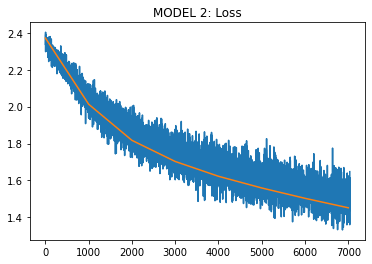

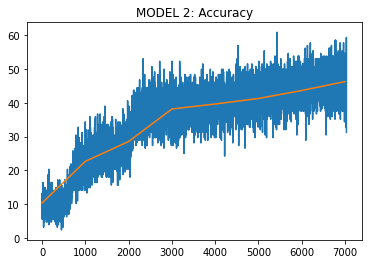

MODEL 5


100%|██████████| 15/15 [01:45<00:00,  7.06s/it]


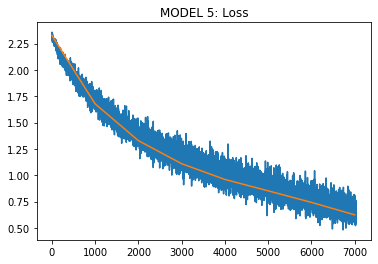

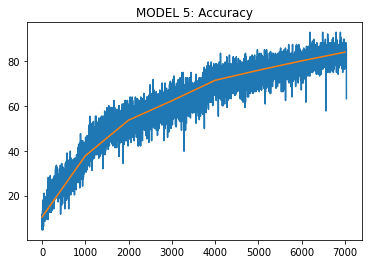

MODEL 10


100%|██████████| 15/15 [01:49<00:00,  7.32s/it]


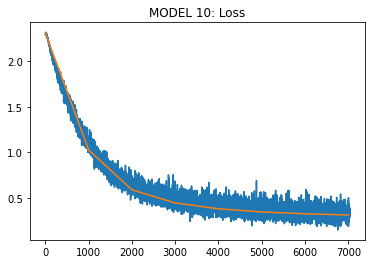

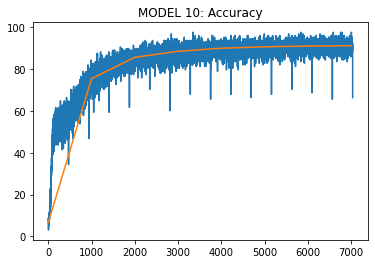

MODEL 20


100%|██████████| 15/15 [01:39<00:00,  6.62s/it]


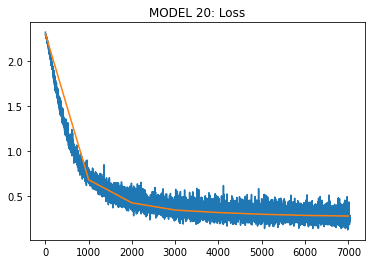

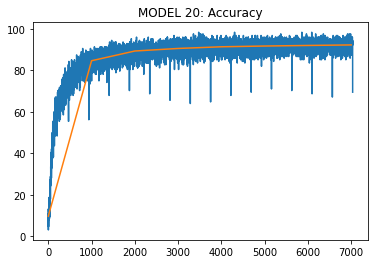

MODEL 50


100%|██████████| 15/15 [01:52<00:00,  7.49s/it]


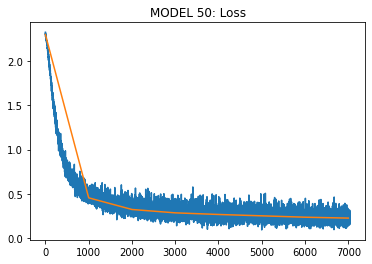

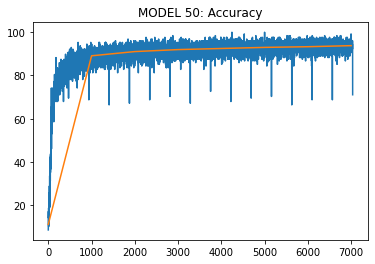

MODEL 100


100%|██████████| 15/15 [01:55<00:00,  7.69s/it]


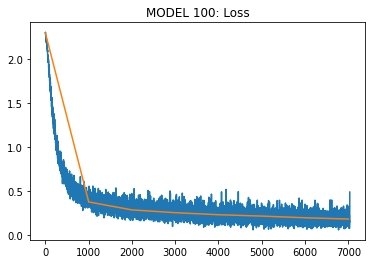

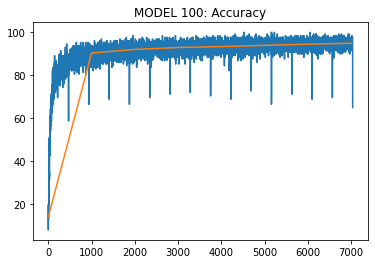

MODEL 1500


100%|██████████| 15/15 [03:54<00:00, 15.65s/it]


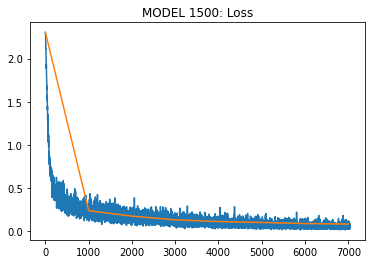

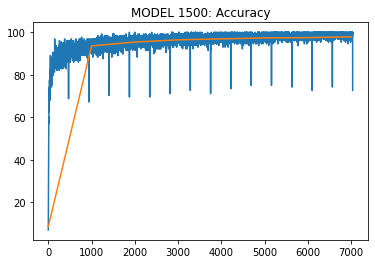

In [5]:
models = []
models_names = []

parameters = dict()

for n in [2, 5, 10, 20, 50, 100, 1500]:
    model = MnistModel(num_of_hidden = n)
    model_name = "MODEL {}".format(n)
    models.append(model)
    models_names.append(model_name)

for model, model_name in zip(models, models_names):
    parameters[model_name] = dict()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    train_model(model, model_name, optimizer)
    for name, param in model.named_parameters():
        if param.requires_grad:
            parameters[model_name][name] = param.data

In [6]:
for model_name in models_names:
    for name in list(parameters[model_name].keys()):
        parameters[model_name][name] = np.array(parameters[model_name][name]).tolist()

with open('parameters.json', 'w') as fp:
    json.dump(parameters, fp)

In [7]:
with open('parameters.json', 'r') as fp:
      parametres = json.load(fp)

### Visualization

Histagrams for first linear layer weights distribution. 

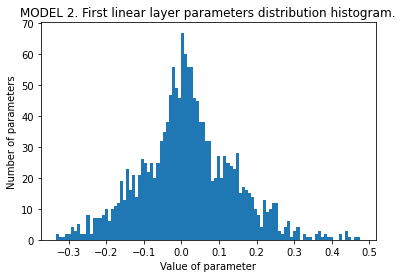

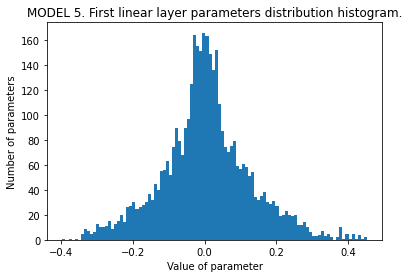

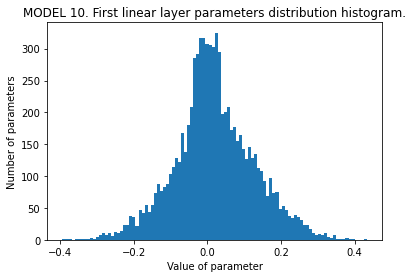

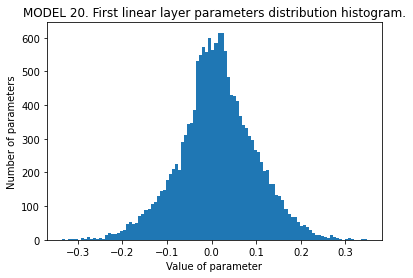

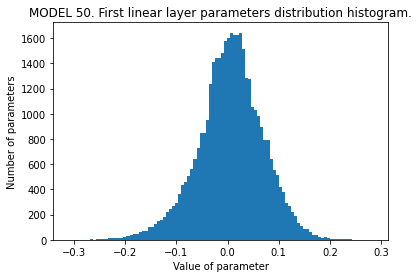

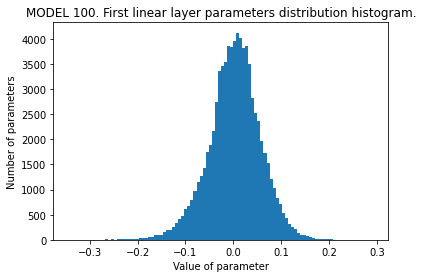

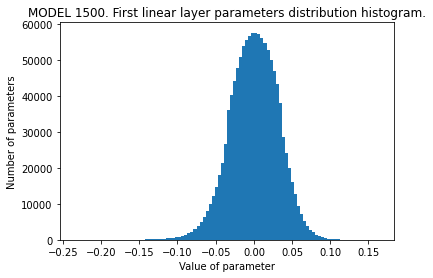

In [22]:
for i, model_name in enumerate(models_names):
    matr = np.array(parameters[model_name]['fc1.weight']).reshape(-1)
    plt.hist(matr, bins = 100)
    plt.title(model_name + ". First linear layer parameters distribution histogram.")
    plt.xlabel("Value of parameter")
    plt.ylabel("Number of parameters")
    plt.show()

### Visualization
Cumulative histagrams for first linear layer weights distribution.

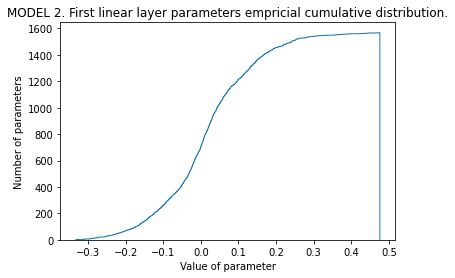

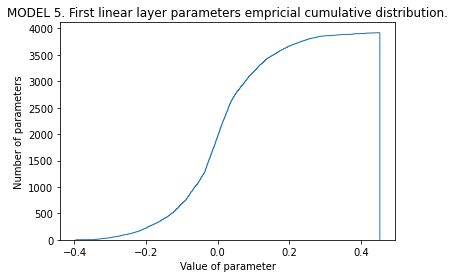

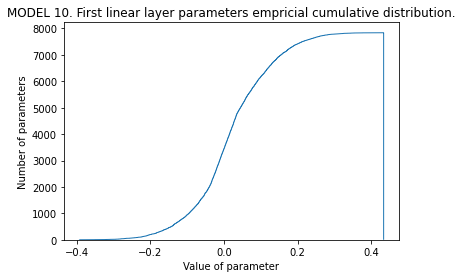

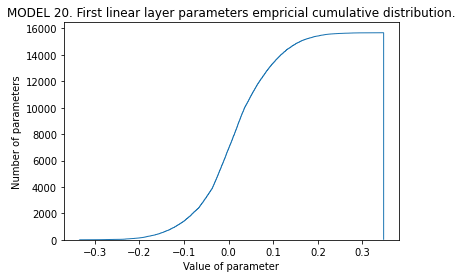

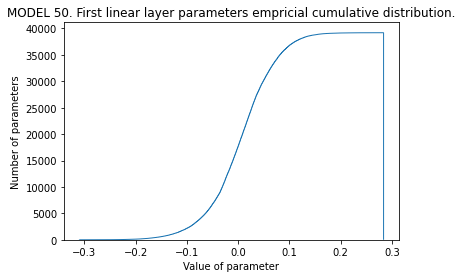

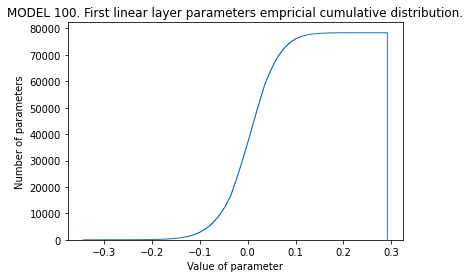

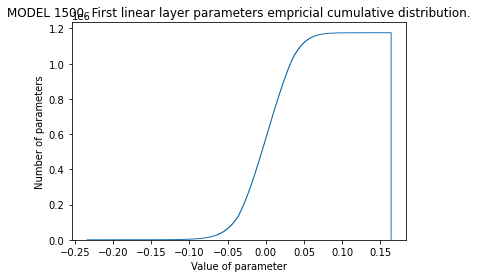

In [25]:
for i, model_name in enumerate(models_names):
    matr = np.array(parameters[model_name]['fc1.weight']).reshape(-1)
    plt.hist(matr, bins = 1000, cumulative=True, histtype = "step")
    plt.title(model_name + ". First linear layer parameters empricial cumulative distribution.")
    plt.xlabel("Value of parameter")
    plt.ylabel("Number of parameters")
    plt.show()

### Conclusion

Models with more parameters on first linear layer in 1-layer neural network have distributions with smaller tails.